执行完后一步的cell之后前面的无法清除，再次执行前面的cell电路图会叠加在后面。
同一个cell执行两遍电路图也会叠加，不想要叠加怎么办？     
执行三次的cy门？  
n个量子比特操作通用门，如何调整其他门覆盖所有可能的变换的？    

In [1]:
import numpy as np
import torch
import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.operator import RZ,ChoiRepr,KrausRepr,StinespringRepr,Oracle
from quairkit.qinfo import *


Horizontal lines水平线代表qubit  
doubled lines双线代表classical bit  
被线连接的item代表对qubit的操作，比如测量，gate等   

the diagram of a quantum circuit:


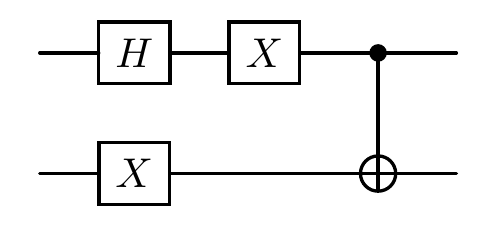

 the total number of qubit of the circuit is3


In [2]:
num_qubits = 3
cir = Circuit(num_qubits)
cir.h(0)
cir.x([0, 1])
cir.cx([0, 1])# CNOT门
print("the diagram of a quantum circuit:")
cir.plot()
print(f" the total number of qubit of the circuit is{cir.num_qubits}")


当一个操作只对单个量子比特作用时，整体是各自门的张量积  
把量子电路翻译成数学上的幺正矩阵

In [3]:
print(f"the unitary matrix of the circuit:\n{cir.matrix}")

the unitary matrix of the circuit:
tensor([[ 0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
         -0.7071+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+0.j, -0.7071+0.j],
        [ 0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j, -0.7071+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j, -0.7071+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.7071+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
          0.7071+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+

为什么这里cir.cy()执行了三次？

the diagram of the quantum circuit with more gates:


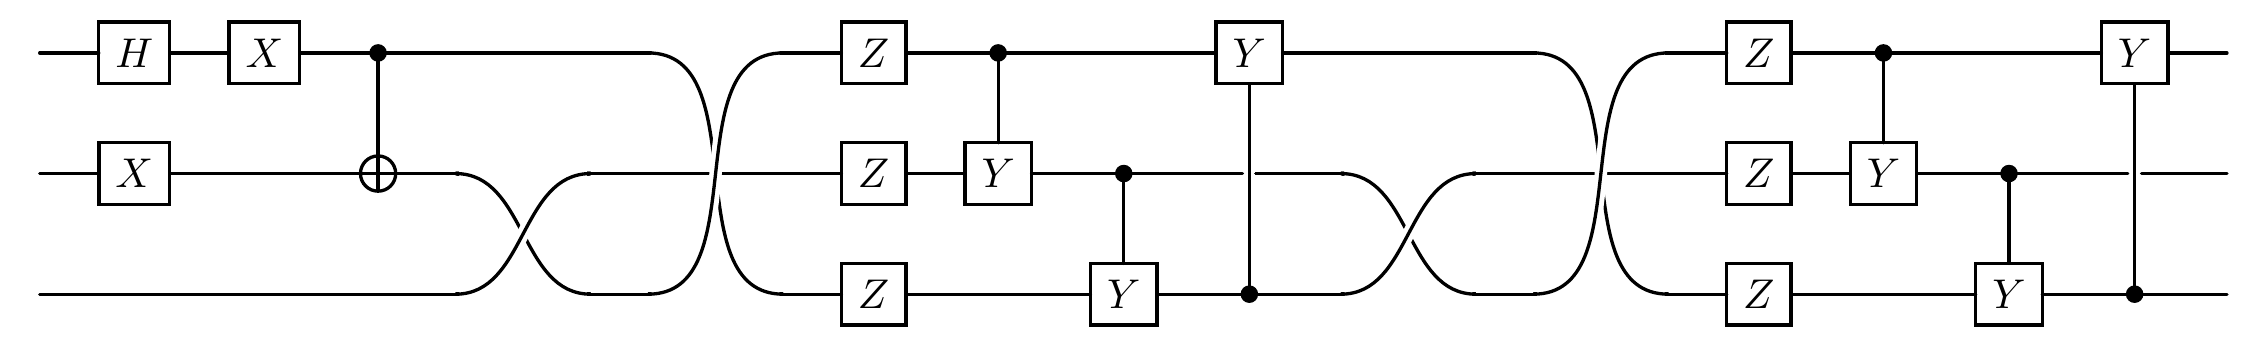

the total number of qubit of the circuit is 3


In [5]:
cir.swap([[1, 2],[0, 2]])
cir.z()
cir.cy()
print("the diagram of the quantum circuit with more gates:")
cir.plot()
print(f"the total number of qubit of the circuit is {cir.num_qubits}")



单量子比特通用门：  

以u3为例：
$$U_3(\theta,\phi,\lambda) = \left[\begin{matrix} cos(\theta/2) & -e^{i\lambda}sin(\theta/2) \\ e ^{i\phi}sin(\theta/2) & e^{i(\phi+\lambda)}cos(\phi/2)\end{matrix}\right]$$  
其中$\theta$表示qubit围绕Y轴的旋转角度，主要控制量子态在 Bloch 球上的 “纬度” 变化（类似地球的纬度），决定了叠加态中 |0⟩ 和 |1⟩ 分量的权重比例     
$\phi$表示绕Z轴的旋转角度，主要控制旋转轴在 XY 平面上的 “方位角”，影响量子态的相位（即 |1⟩ 分量的相位偏移）   
$\lambda$表示绕Z轴的旋转角度，进一步调整量子态的相位，与 φ 配合可以实现任意的全局相位调控   

单量子比特的幺正变换对应的是 3 维旋转群 SU (2)（特殊幺正群），其自由度为 3，即需要 3 个独立参数才能完整描述所有可能的单比特操作。这三个参数通过组合不同轴的旋转，能够生成任意单比特门    


一个 4×4 幺正矩阵有 \(4^2=16\) 个元素，但受幺正性约束（列向量正交且模长为 1），实际自由度为 \(4^2 - 4 = 12\) 个（减去 4 个实约束）。这意味着两量子比特通用门需要至少 12 个独立参数才能覆盖所有可能的变换，而单量子比特门仅需 3 个参数，参数数量的激增直接导致结构复杂。



the diagram of a quantum circuit with parametrized gates:


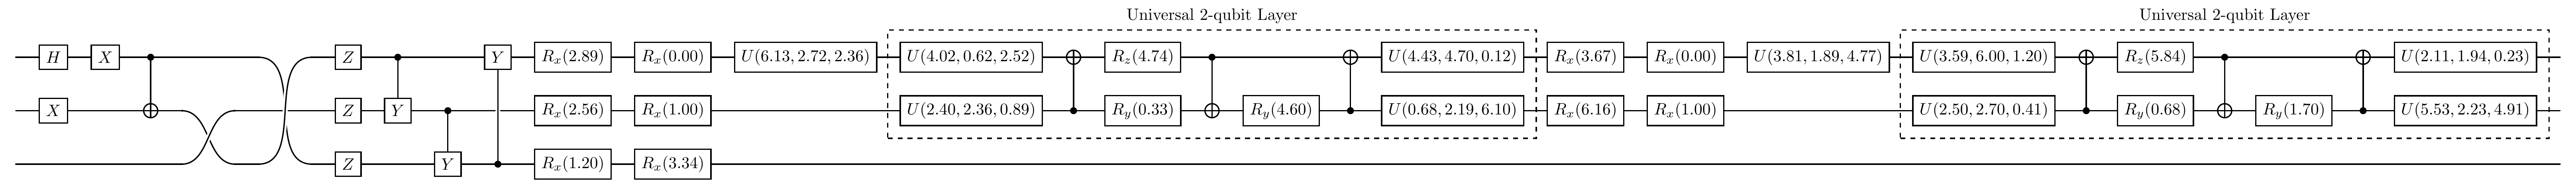

In [23]:

cir.rx()
cir.rx([0, 1], param = np.arange(2))

cir.u3([0])
cir.universal_two_qubits([0, 1])

print("the diagram of a quantum circuit with parametrized gates:")
cir.plot()

对于 n 量子比特的量子傅里叶变换，可以通过递归的方式构建量子电路。先对前 \(n - 1\) 个量子比特进行量子傅里叶变换，然后通过一系列的受控相位门和单比特门操作，将第 n 个量子比特纳入变换过程。

the diagram of a quantum circuit with a custom gate:


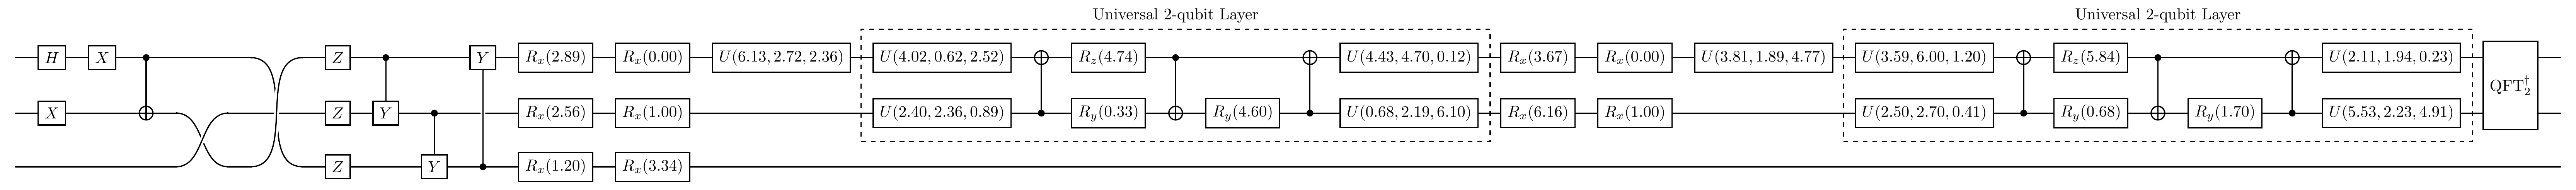

In [24]:
qft_mat = qft_matrix(num_qubits = 2)#构造2量子比特的QFT矩阵
qft_inverse = dagger(qft_mat)#构造QFT的厄米共轭矩阵
cir.oracle(qft_inverse, # 自定义门的矩阵（逆 QFT 矩阵）
           qubits_idx = [0, 1], # 作用的量子比特索引（这里是 qubit 0 和 1 ）
           latex_name = r'\text{QFT}_{2}^{\dagger}')# 电路图中显示的 LaTeX 名称，方便识别
print("the diagram of a quantum circuit with a custom gate:")
cir.plot()
#适用于快捷插入，直接用Circuit里的oracle方法


the diagram of a quantum circuit with a custom gates:


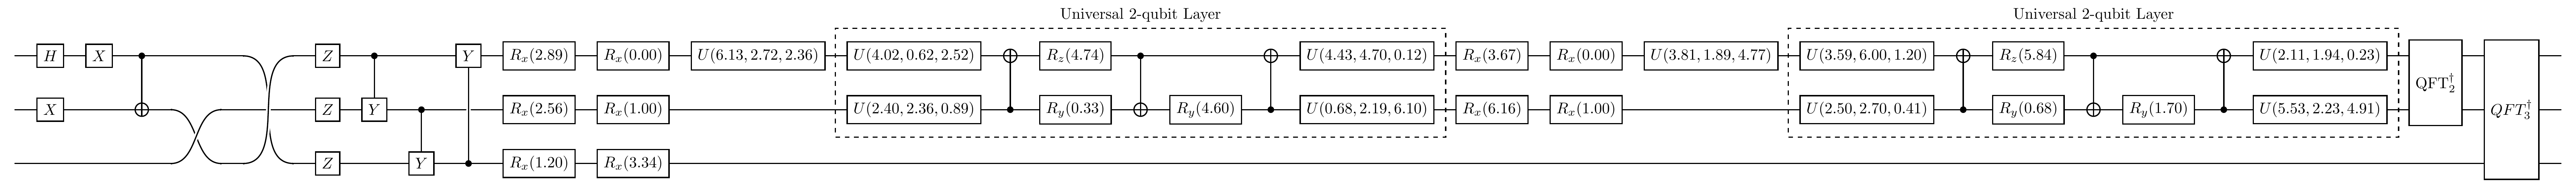

In [25]:
qft_mat = qft_matrix(num_qubits=3)
qft_inverse = dagger(qft_mat)
custom_unitary = Oracle(qft_inverse, 
                        system_idx=list(range(3)), 
                        gate_info={"tex": r'QFT_{3}^{\dagger}'})
cir.append(custom_unitary)
print("the diagram of a quantum circuit with a custom gates:")
cir.plot()
#使用Oracle类预先构造门对象存起来复用  

the diagram of a quantum circuit with a controlled custom gate:


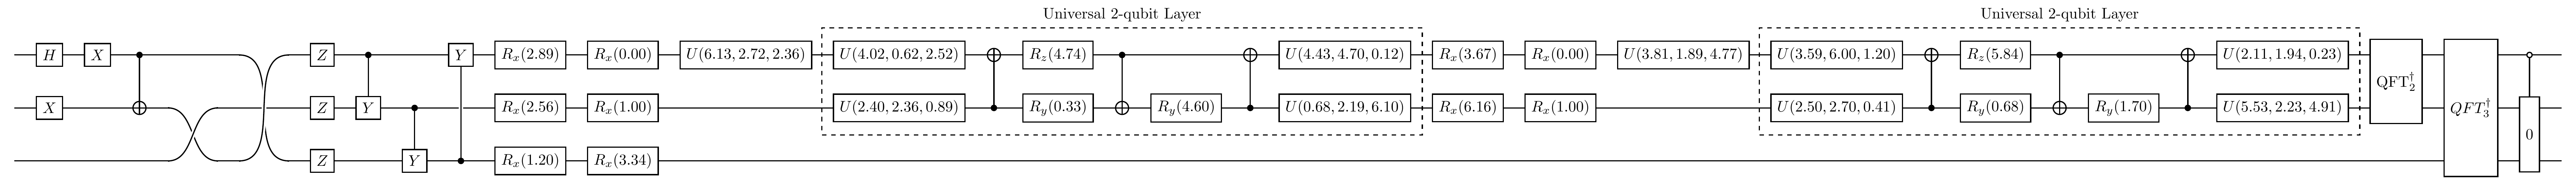

In [26]:
cir.oracle(random_unitary(num_qubits = 2), qubits_idx = [0, 1, 2], control_idx=0, gate_name="0")
print("the diagram of a quantum circuit with a controlled custom gate:")
cir.plot()


In [27]:
cir.depolarizing(prob=0.1, qubits_idx=[0])#给qubit0添加退极化信道，概率为0.1
#退极化信道（Depolarizing Channel）：让量子比特以一定概率 “随机变成混合态”，模拟物理噪声导致的信息丢失；
cir.bit_phase_flip(0.2)#给所有 qubit 加比特-相位翻转信道，概率 0.2  
#比特 - 相位翻转信道（Bit - Phase Flip Channel）：同时翻转量子比特的 “比特态” 和 “相位”，模拟特定噪声环境。

自定义量子信道（构造三种量子信道并插入电路）

In [ ]:
#Choi,适合分析信道的完全正定性
rho = random_state(num_qubits=3)
replacement_choi_repr= replacement_choi(rho)# 用 Choi 矩阵描述信道  
#通过 Choi 矩阵，可计算信道对任意量子态 \(\rho\) 的变换结果
cir.choi_channel(replacement_choi_repr, system_idx=[0, 1, 2])

In [ ]:
#kraus，直观体现 “噪声如何分步破坏量子态”，是最常用的表示之一。
reset_kraus_repr = reset_kraus([0.1, 0.2]) # 用 Kraus 算子列表描述信道  
cir.kraus_channel(reset_kraus_repr, system_idx=2)

In [32]:
#stinespring，适合分析信道的 “输入输出” 关系
random_stin_repr = random_channel(num_systems=1,target="stinespring")
cir.stinespring_channel(random_stin_repr, system_idx=1)


In [33]:
#同样用Choi定义量子信道，适合快速插入
choi_op = random_channel(num_systems=2, #信道作用于 2 个量子比特（即输入是 2 量子比特的密度矩阵）。
                         target="choi")#指定输出信道的表示形式为 Choi 矩阵
choi_repr =ChoiRepr(choi_op, system_idx=[1, 2])#将 Choi 矩阵 封装为 “可插入量子电路的门对象”，指定作用的量子比特。
cir.append(choi_repr)


kraus_op = random_channel(num_systems=1, target = "kraus")
kraus_repr=KrausRepr(kraus_op, system_idx=0)
cir.append(kraus_repr)

stine_op = random_channel(num_systems=1, target="stinespring")
stine_repr = StinespringRepr(stine_op, system_idx=[0, 1, 2])
cir.append(stine_repr)

Circuit(
  (0): H()
  (1): X()
  (2): CNOT()
  (3): SWAP()
  (4): Z()
  (5): CY()
  (6): RX()
  (7): RX()
  (8): U3()
  (9): Universal2(
    (0): U3()
    (1): CNOT()
    (2): RZ()
    (3): RY()
    (4): CNOT()
    (5): RY()
    (6): CNOT()
    (7): U3()
  )
  (10): RX()
  (11): RX()
  (12): U3()
  (13): Universal2(
    (0): U3()
    (1): CNOT()
    (2): RZ()
    (3): RY()
    (4): CNOT()
    (5): RY()
    (6): CNOT()
    (7): U3()
  )
  (14): Oracle()
  (15): Oracle()
  (16): ControlOracle()
  (17): Depolarizing()
  (18): BitPhaseFlip()
  (19): ChoiRepr()
  (20): KrausRepr()
  (21): StinespringRepr()
  (22): ChoiRepr()
  (23): KrausRepr()
  (24): StinespringRepr()
)

the diagram of a quantum circuit with different kinds of layers:


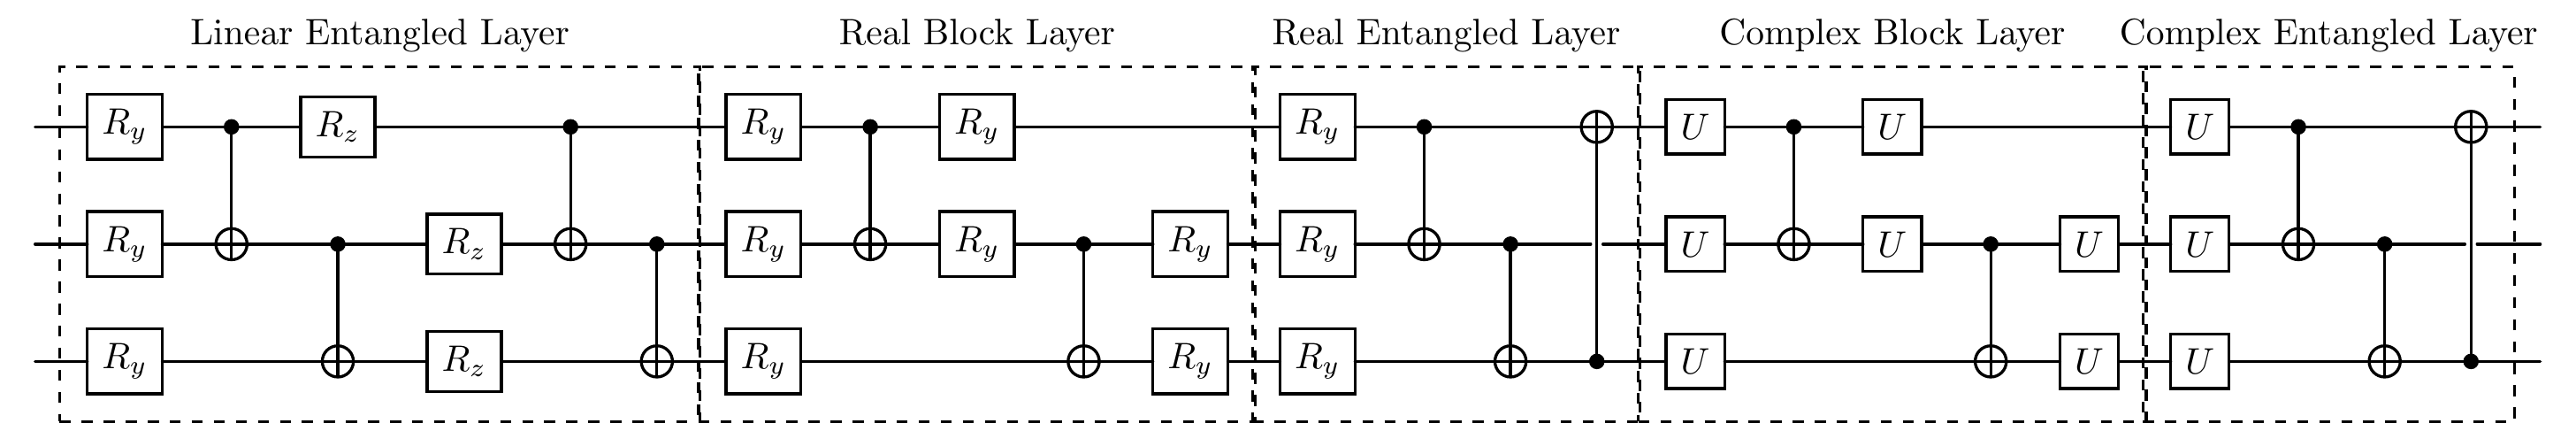

In [ ]:
#预定义模板（适用于已知量子比特数目的信道）
num_qubits = 3
cir = Circuit(num_qubits)
cir.linear_entangled_layer(depth=1)
#在 3 个 qubit 间，按 “线性排列” 的方式添加纠缠门（如 CNOT、CZ ）和单比特旋转门（如 \(R_x、R_y\) ），depth=1 表示加 1 层这样的结构。
cir.real_block_layer(depth=1)  
#侧重用 “实数值参数” 的旋转门（如 \(R_x、R_y\) 用实数角度 ），按 “块结构” 组织（比如 2 个 qubit 为一组加门 ）；
cir.real_entangled_layer(depth=1)  
#在实参数旋转门基础上，强化 qubit 间的纠缠操作（更多 CNOT 这类受控门 ），同样用实参数。
cir.complex_block_layer(depth=1) 
cir.complex_entangled_layer(depth=1) 
#和 “实参数层” 类似，但旋转门的参数可以是复数（更灵活，覆盖更多量子态变换 ）；
print("the diagram of a quantum circuit with different kinds of layers:")
cir.plot(style='compact')

In [36]:
#operations就是circuit的object，通过打印它就可以获得operations
print("The unitary matrix of the first layer is\n", cir[0].matrix.detach().numpy())

The unitary matrix of the first layer is
 [[ 0.27800164+0.3024881j   0.05601787+0.06095195j  0.3297584 +0.3588037j
   0.06644697+0.07229964j -0.32484663-0.35345927j -0.06545723-0.07122274j
  -0.3853248 -0.41926438j -0.0776437 -0.0844826j ]
 [ 0.06983405+0.04445613j -0.3465676 -0.22062378j  0.08283537+0.05273272j
  -0.4110896 -0.2616983j  -0.08160152-0.05194727j  0.4049664 +0.2578003j
  -0.09679364-0.06161852j  0.48036084+0.30579615j]
 [-0.45360553-0.17810877j -0.09140241-0.03588927j  0.38241044+0.15015393j
   0.07705646+0.03025631j  0.53004086+0.20812124j  0.10680428+0.04193684j
  -0.446849  -0.17545581j -0.09004096-0.0353547j ]
 [-0.07906549-0.05823305j  0.3923807 +0.28899494j  0.06665587+0.04909315j
  -0.33079508-0.2436361j   0.09238851+0.06804568j -0.4584993 -0.33769244j
  -0.0778878 -0.05736566j  0.38653612+0.28469032j]
 [ 0.08160152-0.05194727j -0.4049664 +0.2578003j   0.09679364-0.06161852j
  -0.48036084+0.30579615j  0.06983405-0.04445613j -0.3465676 +0.22062378j
   0.08283537-0.

The quantum circuit after adding gates is:


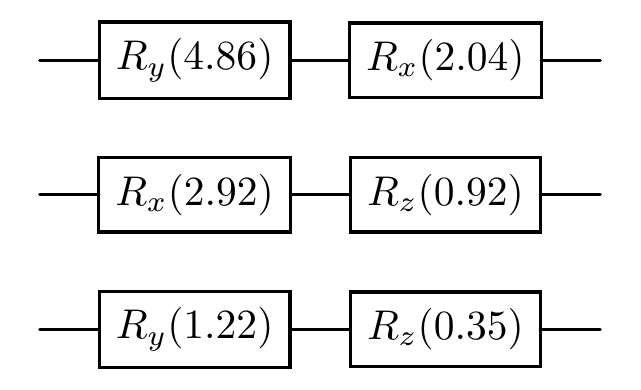

The quantum circuit after removing gates is:


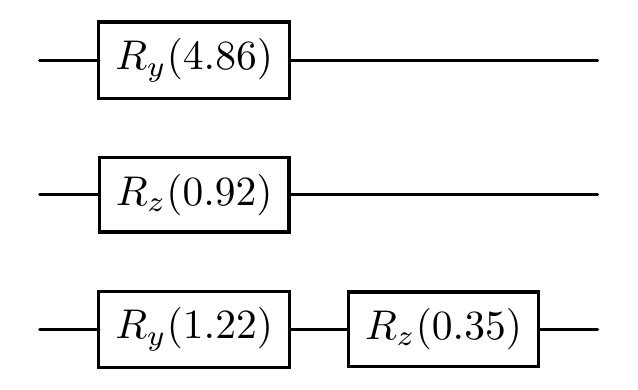

In [37]:
cir = Circuit(num_qubits=3)
param = np.random.rand(2)#随机生成两个参数用于RX门的旋转角度
rz_gate =RZ(param=param, qubits_idx = [1, 2])
cir.ry([0, 2])
cir.rx([0, 1])
cir.insert(index=2, module=rz_gate)

print("The quantum circuit after adding gates is:")
cir.plot()
cir.pop(1)
print("The quantum circuit after removing gates is:")
cir.plot()


In [38]:
# 让构建好的量子电路作用于不同初始量子态，得到输出态
#第一次拿默认全0态输入这个电路进行操作
output_state = cir()
print("the output state for inputting zero state is:", output_state)

#第二次拿随机生成的一个态输入这个电路进行操作
rho = random_state(3)
output_state = cir(rho)
print("the output state foe inputting state rho is:", output_state)



the output state for inputting zero state is: 
-----------------------------------------------------
 Backend: state_vector
 System dimension: [2, 2, 2]
 System sequence: [2, 1, 0]
[-0.5 +0.37j  0.43-0.32j  0.  +0.j    0.  +0.j   -0.42+0.12j  0.36-0.11j
  0.  +0.j    0.  +0.j  ]
-----------------------------------------------------

the output state foe inputting state rho is: 
-----------------------------------------------------
 Backend: state_vector
 System dimension: [2, 2, 2]
 System sequence: [2, 1, 0]
[ 0.06-0.17j  0.3 +0.17j -0.35-0.1j   0.09+0.03j  0.46-0.1j   0.44-0.2j
  0.08-0.47j  0.17+0.02j]
-----------------------------------------------------



In [ ]:
cir
#直接打印 cir 对象，框架会输出电路的简洁摘要（包含门的类型、作用的量子比特 ），快速了解电路有哪些门。

Circuit(
  (0): RY()
  (1): RZ()
)

In [ ]:
print("the circuit depth is", cir.depth, "\h")
print("the gate history of the circuit is\n", cir.operator_history)
#operator_history追溯电路构建过程，提取门参数，用于优化算法/复现电路逻辑等
#其内容严格依赖构建电路的实际步骤，必须先执行完所有电路构建代码

the circuit depth is 2 \h
the gate history of the circuit is
 [{'name': 'ry', 'type': 'gate', 'tex': 'R_{y}', 'api': 'ry', 'param_sharing': False, 'plot_width': 0.9, 'system_idx': [[0], [2]], 'param': Parameter containing:
tensor([[[4.8633]],

        [[1.2245]]], requires_grad=True), 'matrix': tensor([[[-0.7584+0.j, -0.6518+0.j],
         [ 0.6518+0.j, -0.7584+0.j]],

        [[ 0.8183+0.j, -0.5747+0.j],
         [ 0.5747+0.j,  0.8183+0.j]]], grad_fn=<SqueezeBackward0>)}, {'name': 'rz', 'type': 'gate', 'tex': 'R_{z}', 'api': 'rz', 'param_sharing': False, 'plot_width': 0.9, 'system_idx': [[1], [2]], 'param': tensor([[[0.9242]],

        [[0.3477]]]), 'matrix': tensor([[[0.8951-0.4458j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.8951+0.4458j]],

        [[0.9849-0.1730j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.9849+0.1730j]]])}]


In [ ]:
print("the trainable parameters of entire circuit are:", cir.param)
# 直接打印 cir.param，查看电路中所有可训练参数的列表

cir.update_param(torch.ones_like(cir.param))
#参数值全部更新为1
print("the updated trainable parameters of entire circuit are", cir.param)


the trainable parameters of entire circuit are: tensor([4.8633, 1.2245])
the updated trainable parameters of entire circuit are tensor([1., 1.])
